# NYC Yellow Taxi Fare Prediction

## Import Necessary Libraries

In [1]:
## Import necessary libraries
import pandas as pd
import numpy as np
import random 
from urllib.parse import quote
from datetime import timedelta, datetime

## Import necessary API
import sys
sys.path.append('../../../../')
from api.v2.util.data_load import data_load
from api.v2.model.ResNet1d import ResidualBlock, ResNet1D
from api.v2.util.set_minmax import set_minmax_value
from api.v2.Preprocessing.MinMaxScaler import MinMaxScaler
from api.v2.util.compare_graph import compare_graph

## Import libraries for the model
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange
from sklearn.metrics import mean_squared_error, r2_score

## Set path for saving model training results
import os
os.makedirs('./result', exist_ok=True)

## Set Cuda for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Set random seed
def set_seed(seed_val):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

# Set seed
seed_val = 77
set_seed(seed_val)

cuda


## Base Parameter Setting
* Set parameters based on the information identified during EDA (Exploratory Data Analysis).

In [2]:
# Set Bitcoin Data Parameter

# Set MachBase Neo URL address
URL = 'http://127.0.0.1:5654'
# Set Tag Table Name
table = 'taxi'
# Select Tag Name -> Can Check Tag Names Using command 'show_column(URL, table)'
tags = ['extra', 'fare_amount', 'improvement_surcharge', 'mta_tax', 'passenger_count', 'payment_type', 'tip_amount', 'tolls_amount', 'trip_distance', 'trip_duration_minutes', 'total_amount']
# Wrap each item in the list with single quotes and separate with commas
tags_ = ",".join(f"'{tag}'" for tag in tags)
# Set Tag Name
name = quote(tags_, safe=":/")
# Set resample Option -> D(day), H(hour), T(minute), S(second)
resample_freq = None
# Set Start time
start_time = '2015-01-01 00:00:00'
# Set End time 
end_time = '2015-02-01 00:00:00'
# Set TimeFormat - > 'default' or quote('2006-01-02 15:04:05.000000')(Divided down to the nanosecond)
timeformat = 'default'

## Model Configuration
* Using ResNet1d model.

In [3]:
# Model configuration parameters

# Set ResidualBlock
block = ResidualBlock
# Set the number of ResidualBlocks to use per layer
layers = [2,2,2,2]
# Set the number of classification categories
num_classes = 1

# Learning rate
lr = 0.001

# Model configuration
model = ResNet1D(block, layers, num_classes).to(device)

# Configure loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Check the model architecture
print(model)

ResNet1D(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), paddi

## Dataset & Loader Setup

In [4]:
class Taxi_Dataset(Dataset):

    def __init__(self, df):
        self.freq_data = df.iloc[:,:-1]
        self.label = df.iloc[:,-1:].values

    def __len__(self):
        return len(self.freq_data)

    def __getitem__(self, index):

        input_time_data = self.freq_data.iloc[index,:]
        input_time_data = torch.Tensor(input_time_data).expand(1, input_time_data.shape[0])
        label = self.label[index]

        return input_time_data, label

## Model Training

In [5]:
# Model training function
def train(epochs, start_time_train, end_time_train, start_time_valid, end_time_valid, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_feature, scaler_target, Min, Max, batch_size):
    
    # Initialize loss
    train_loss = []
    
    # Initialize best Loss value
    best_Loss= np.inf
    
    # Start model training
    for epoch in epochs:
        
        # Set the model to training mode
        model.train()
        
        # Initialize loss and total step
        running_loss = 0.0
        total_step = 0
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_train
        end_time = str(datetime.strptime(start_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_train_ = str(datetime.strptime(end_time_train, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False

        while end_time < end_time_train_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)
            
            # Apply MinMaxscaler
            data_feature = scaler_feature.fit_transform(data.drop(['total_amount'], axis=1).values, Min.drop(columns=[8]).values, Max.drop(columns=[8]).values)
            data_target = scaler_target.fit_transform(data['total_amount'].values.reshape(-1, 1), Min[8].values, Max[8].values)
            
            # Set up the DataFrame
            data = pd.DataFrame(data_feature, columns=data.drop(['total_amount'], axis=1).columns)
            data['total_amount'] = data_target

            # Set up dataset & Loader
            train_ = Taxi_Dataset(data)
            train_dataloader = DataLoader(train_, batch_size, shuffle=True)

            # Print if the loaded data is empty
            if len(data) != 0:
                
                for batch_idx, (data, target) in enumerate(train_dataloader):
                    
                    # Check total batch count
                    total_step += 1
                    
                    data = data.to(device).float()
                    target = target.to(device).float()
                    
                    optimizer.zero_grad()
                
                    # Input to the model
                    outputs = model(data)
                    
                    # Calculate loss
                    loss = criterion(outputs, target)
                    loss.backward()
                    optimizer.step()
                    
                    running_loss += loss.item()
                    
            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_train and not flag:
                
                end_time = end_time_train
                flag = True   

        # Print training loss
        train_loss.append(running_loss / total_step)
        print(f'\ntrain loss: {np.mean(train_loss)}')    
        
        # Initialize loss
        valid_loss = []
        
        # Perform validation at the end of each epoch and save the model with the best performance
        with torch.no_grad():
            
            model.eval()        
            
            # Initialize loss and total step
            running_loss = 0.0
            total_step = 0
        
            # Set initial Time
            args = {unit: Fetch_size}
            start_time = start_time_valid
            end_time = str(datetime.strptime(start_time_valid, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            end_time_valid_ = str(datetime.strptime(end_time_valid, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
            # Set flag
            flag = False
            
            while end_time < end_time_valid_:
            
                # Load batch data
                data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)
                
                # Apply MinMaxscaler
                data_feature = scaler_feature.fit_transform(data.drop(['total_amount'], axis=1).values, Min.drop(columns=[8]).values, Max.drop(columns=[8]).values)
                data_target = scaler_target.fit_transform(data['total_amount'].values.reshape(-1, 1), Min[8].values, Max[8].values)
                
                # Set up the DataFrame
                data = pd.DataFrame(data_feature, columns=data.drop(['total_amount'], axis=1).columns)
                data['total_amount'] = data_target

                # Set up dataset & Loader
                valid_ = Taxi_Dataset(data)
                valid_dataloader = DataLoader(valid_, batch_size, shuffle=True)

                # Print if the loaded data is empty
                if len(data) != 0:
                    
                    for batch_idx, (data, target) in enumerate(valid_dataloader):
                        
                        # Check total batch count
                        total_step += 1
                        
                        data = data.to(device).float()
                        target = target.to(device).float()
                    
                        # Input to the model
                        outputs = model(data)
                        
                        # Calculate loss
                        loss = criterion(outputs, target)
                        
                        running_loss += loss.item()
                        
                # Update start_time and end_time for next batch
                start_time = end_time
                end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
                
                # Select the remaining portions at the end
                if end_time >= end_time_valid and not flag:
                    
                    end_time = end_time_valid
                    flag = True   
                    
            valid_loss.append(running_loss / total_step)

            # Save the model if it has the best loss
            if best_Loss > np.mean(valid_loss):
                best_Loss = np.mean(valid_loss)
                torch.save(model, f'./result/NYC_Yellow_Taxi_Buffered_Fetch.pt')
                print('Model saved')
            epochs.set_postfix_str(f"epoch = {epoch}, best_Loss = {best_Loss}")
     
    return model

In [6]:
# Set number of epochs
epochs = trange(10, desc='training')
# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 5
# Set Batch Size
batch_size = 256
# Set Train Time
start_time_train = '2015-01-01 00:00:00'
end_time_train = '2015-01-20 00:00:00'
# Set Valid Time
start_time_valid = '2015-01-20 00:00:00'
end_time_valid = '2015-01-25 00:00:00'
# Set up scalers
scaler_feature = MinMaxScaler()
scaler_target = MinMaxScaler()
# Set Min, Max value
Min, Max = set_minmax_value(URL, table, name, start_time_train, end_time_train)

#################################################################Training#############################################################################################
train(epochs, start_time_train, end_time_train, start_time_valid, end_time_valid, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_feature, scaler_target, Min, Max, batch_size)

training:   0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\co


train loss: 0.005149726626772501


c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


Model saved

train loss: 0.0026879777758267932
Model saved

train loss: 0.0018589823811185084

train loss: 0.0014459024630219385
Model saved

train loss: 0.0011906090453753055

train loss: 0.0010099770228445594

train loss: 0.0008732499433397468
Model saved

train loss: 0.0007701495415974594

train loss: 0.0006884447321334227
Model saved

train loss: 0.0006210221002690643


ResNet1D(
  (conv1): Conv1d(1, 64, kernel_size=(7,), stride=(2,), padding=(3,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), paddi

## Model Test

In [7]:
def test(model, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_feature, scaler_target, Min, Max, batch_size):
    
    with torch.no_grad():
                
        model.eval()
        
        # Initial settings 
        output_test = []
        output_target = []
        
        # Set initial Time
        args = {unit: Fetch_size}
        start_time = start_time_test
        end_time = str(datetime.strptime(start_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
        end_time_test_ = str(datetime.strptime(end_time_test, "%Y-%m-%d %H:%M:%S") + timedelta(seconds=1))
        
        # Set flag
        flag = False
        
        while end_time < end_time_test_:
            
            # Load batch data
            data = data_load(URL, table, name, start_time, end_time, timeformat, resample_freq)
            
            # Apply MinMaxscaler
            data_feature = scaler_feature.fit_transform(data.drop(['total_amount'], axis=1).values, Min.drop(columns=[8]).values, Max.drop(columns=[8]).values)
            data_target = scaler_target.fit_transform(data['total_amount'].values.reshape(-1, 1), Min[8].values, Max[8].values)
            
            # Set up the DataFrame
            data = pd.DataFrame(data_feature, columns=data.drop(['total_amount'], axis=1).columns)
            data['total_amount'] = data_target

            # Set up dataset & Loader
            test_ = Taxi_Dataset(data)
            test_dataloader = DataLoader(test_, batch_size, shuffle=False)
            
            # Print if the loaded data is empty
            if len(data) != 0:
                
                for batch_idx, (data, target) in enumerate(test_dataloader):
                    
                    data = data.to(device).float()
                    target = target.to(device).float()
                
                    # Input to the model
                    outputs = model(data)
                    
                    output_test.append(outputs)
                    output_target.append(target)
        
            # Update start_time and end_time for next batch
            start_time = end_time
            end_time = str(datetime.strptime(start_time, "%Y-%m-%d %H:%M:%S") + timedelta(**args))
            
            # Select the remaining portions at the end
            if end_time >= end_time_test and not flag:
                
                end_time = end_time_test
                flag = True   
 
    # Combine tensors into one
    combined_tensor_target = torch.cat(output_target, dim=0).cpu()
    combined_tensor_pred = torch.cat(output_test, dim=0).cpu()

    # Inverse transform using MinMaxScaler 
    real_values = scaler_target.inverse_transform(combined_tensor_target.numpy().reshape(-1, 1))
    real_pred_values = scaler_target.inverse_transform(combined_tensor_pred.numpy().reshape(-1, 1))   
        
    return real_values, real_pred_values

In [8]:
# Load the best model
model_ = torch.load(f'./result/NYC_Yellow_Taxi_Buffered_Fetch.pt')

# Unit of time ('days', 'hours', 'minutes', 'seconds')
unit = 'days'
Fetch_size = 5
# Set Test Tiem
start_time_test = '2015-01-25 00:00:00'
end_time_test = '2015-02-01 00:00:00'

##################################################################################Test############################################################################################################
real_values, real_pred_values = test(model_, start_time_test, end_time_test, unit, Fetch_size, URL, table, name, timeformat, resample_freq, scaler_feature, scaler_target, Min, Max, batch_size)

c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
c:\Users\MACH-DE-28\anaconda3\envs\test\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,


## Model Performance Evaluation

In [9]:
# Calculate MSE
mse = mean_squared_error(real_values, real_pred_values)
print("Mean Squared Error:", mse)

# Calculate R² Score
r2 = r2_score(real_values, real_pred_values)
print("R² Score:", r2)

Mean Squared Error: 1.1537788125727453
R² Score: 0.9915584099254221


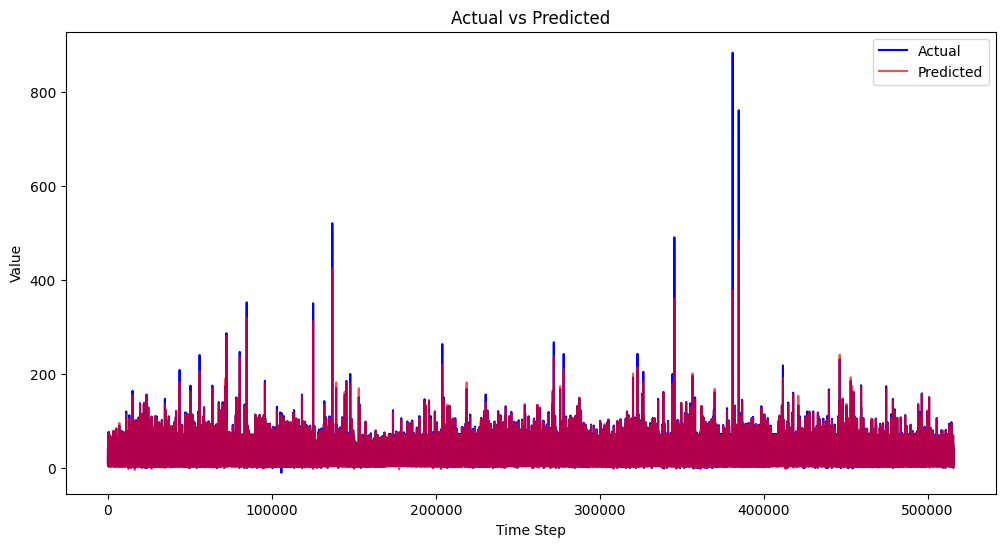

In [10]:
# Compare the test results: Actual values vs Predicted values

# Plot width
x_size=12
# Plot height
y_size=6
# Print Compare_graph
compare_graph(real_values, real_pred_values, x_size, y_size)